Now that we know that our best model is made with the VGG16 pretrained model we can use a new file

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Hyperparameters
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS= 3
ES_EPOCHS = 20 
CLASSES = 10
EPOCHS= 500

In [4]:
CLASS_NAMES = ["1989", "Acoustic", "Fearless", "Folkmore", "Lover", "Midnights", "Red", "Reputation", "Speak Now", "TTPD"]

Create the data splits

In [5]:
import os
import shutil
import random

def split_dataset(folder_path, output_path, train_split=0.8, test_split=0.1, 
                   val_split=0.1, shuffle=True):
    """
    Splits the images in the given folder into train, test, and validation sets,
    and moves them to the specified output path, ensuring no duplicate moves.

    Args:
        folder_path (str): Path to the folder containing the images.
        output_path (str): Path to the directory where the split datasets 
                          will be saved.
        train_split (float, optional): Ratio of images for training (0.0 to 1.0). 
                                     Defaults to 0.8.
        test_split (float, optional): Ratio of images for testing (0.0 to 1.0). 
                                    Defaults to 0.1.
        val_split (float, optional): Ratio of images for validation (0.0 to 1.0). 
                                    Defaults to 0.1.
        shuffle (bool, optional): Whether to shuffle the images. Defaults to True.
        shuffle_size (int, optional): Size of the shuffle buffer. Defaults to 1000.
    """

    if train_split + test_split + val_split != 1.0:
        raise ValueError("Train, test, and validation splits must add up to 1.0")

    # Create output directory if it doesn't exist
    os.makedirs(output_path, exist_ok=True)

    # Create subfolders for train, test, and validation in the output directory
    for subfolder in ["train", "test", "val"]:
        os.makedirs(os.path.join(output_path, subfolder), exist_ok=True)

    # Get list of image files in the folder
    image_files = [
        f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))
    ]

    # Shuffle the image files
    if shuffle:
        random.shuffle(image_files)

    # Calculate the number of images for each set
    num_images = len(image_files)
    num_train = int(num_images * train_split)
    num_test = int(num_images * test_split)

    # Split the image files into sets
    train_files = image_files[:num_train]
    test_files = image_files[num_train : num_train + num_test]
    val_files = image_files[num_train + num_test :]

    # Move images to corresponding subfolders, preventing duplicates
    for file_list, subfolder in zip(
        [train_files, test_files, val_files], ["train", "test", "val"]
    ):
        for image_file in file_list:
            src_path = os.path.join(folder_path, image_file)
            dest_path = os.path.join(output_path, subfolder, image_file)
            if not os.path.exists(dest_path):  # Check if file already exists
                shutil.move(src_path, dest_path) 
 

Create the classes

In [6]:
def organize_images(directory):
  """Organizes images in a directory into subfolders based on the first word of their filenames.

  Args:
    directory: The path to the directory containing the images.
  """

  for filename in os.listdir(directory):
    if filename.endswith(('.jpg', '.jpeg', '.png', '.gif')):  # Adjust file extensions if needed
      file_path = os.path.join(directory, filename)
      folder_name = filename.split('_')[0]  # Extract the first word before "_"
      folder_path = os.path.join(directory, folder_name)

      # Create the folder if it doesn't exist
      if not os.path.exists(folder_path):
        os.makedirs(folder_path)

      # Move the image to the corresponding folder
      shutil.move(file_path, os.path.join(folder_path, filename))

In [7]:
output_path = "C:\\Users\\Ronan\\Documents\\ML\\Taylor_Swift_Projects\\CNN\\"

# 1989
_1989_path = "C:\\Users\\Ronan\\Documents\\ML\\Taylor_Swift_Projects\\CNN\\Eras_Tour_Movie_Dataset\\1989"
split_dataset(_1989_path, output_path) 

# Acoustic
acoustic_path = "C:\\Users\\Ronan\\Documents\\ML\\Taylor_Swift_Projects\\CNN\\Eras_Tour_Movie_Dataset\\Acoustic"
split_dataset(acoustic_path, output_path) 

# Fearless
fearless_path = "C:\\Users\\Ronan\\Documents\\ML\\Taylor_Swift_Projects\\CNN\\Eras_Tour_Movie_Dataset\\Fearless"
split_dataset(fearless_path, output_path)

# Folkmore
folkmore_path = "C:\\Users\\Ronan\\Documents\\ML\\Taylor_Swift_Projects\\CNN\\Eras_Tour_Movie_Dataset\\Folkmore"
split_dataset(folkmore_path, output_path)

# Lover
lover_path = "C:\\Users\\Ronan\\Documents\\ML\\Taylor_Swift_Projects\\CNN\\Eras_Tour_Movie_Dataset\\Lover"
split_dataset(lover_path, output_path)

# Midnights
midnights_path = "C:\\Users\\Ronan\\Documents\\ML\\Taylor_Swift_Projects\\CNN\\Eras_Tour_Movie_Dataset\\Midnights"
split_dataset(midnights_path, output_path)

# Red
red_path = "C:\\Users\\Ronan\\Documents\\ML\\Taylor_Swift_Projects\\CNN\\Eras_Tour_Movie_Dataset\\Red"
split_dataset(red_path, output_path)

# Reputation
reputation_path = "C:\\Users\\Ronan\\Documents\\ML\\Taylor_Swift_Projects\\CNN\\Eras_Tour_Movie_Dataset\\Reputation"
split_dataset(reputation_path, output_path)

# Speak Now
speak_now_path = "C:\\Users\\Ronan\\Documents\\ML\\Taylor_Swift_Projects\\CNN\\Eras_Tour_Movie_Dataset\\Speak_Now"
split_dataset(speak_now_path, output_path)

# TTPD
ttpd_path = "C:\\Users\\Ronan\\Documents\\ML\\Taylor_Swift_Projects\\CNN\\Eras_Tour_Movie_Dataset\\TTPD"
split_dataset(ttpd_path, output_path)

In [8]:
# Train
train_directory = "C:/Users/Ronan/Documents/ML/Taylor_Swift_Projects/CNN/train"
organize_images(train_directory)

# Val
val_directory = "C:/Users/Ronan/Documents/ML/Taylor_Swift_Projects/CNN/val"
organize_images(val_directory)

# Test
test_directory = "C:/Users/Ronan/Documents/ML/Taylor_Swift_Projects/CNN/test"
organize_images(test_directory)

In [9]:
# Directory with the images
test_dir = "C:/Users/Ronan/Documents/ML/Taylor_Swift_Projects/CNN/test"
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    seed=42,
    label_mode='int',
    validation_split=None,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

Found 780 files belonging to 10 classes.


In [10]:
# Directory with the images
train_dir = "C:/Users/Ronan/Documents/ML/Taylor_Swift_Projects/CNN/train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    seed = 42,
    label_mode='int',
    validation_split=None,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 4409 files belonging to 10 classes.


In [11]:
# Directory with the images
val_dir = "C:/Users/Ronan/Documents/ML/Taylor_Swift_Projects/CNN/val"
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    seed = 42,
    label_mode='int',
    validation_split=None,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 819 files belonging to 10 classes.


In [12]:
print(f"""
    ----------------------------------
    Dataset split:
        - train split: {len(train_ds)}
        - val split: {len(val_ds)}
        - test split: {len(test_ds)}
    ----------------------------------
    """
)


    ----------------------------------
    Dataset split:
        - train split: 276
        - val split: 52
        - test split: 49
    ----------------------------------
    


In [13]:
#Caching the dataset

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
# Normalize and rescale the images
#resize_and_rescale = tf.keras.Sequential([
#  tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
#  tf.keras.layers.Rescaling(1./255),
#])

In [15]:
# Proof that the images are rescaled
#normalized_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y))
#image_batch, labels_batch = next(iter(normalized_ds))
#first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))

In [16]:
# Import keras api 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [17]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomContrast(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomBrightness(factor=0.2)
])

In [18]:
#train_ds = train_ds.map(
#    lambda x, y: (data_augmentation(x, training=True), y)
#).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
import os
import seaborn as sns
main_folder = 'train'

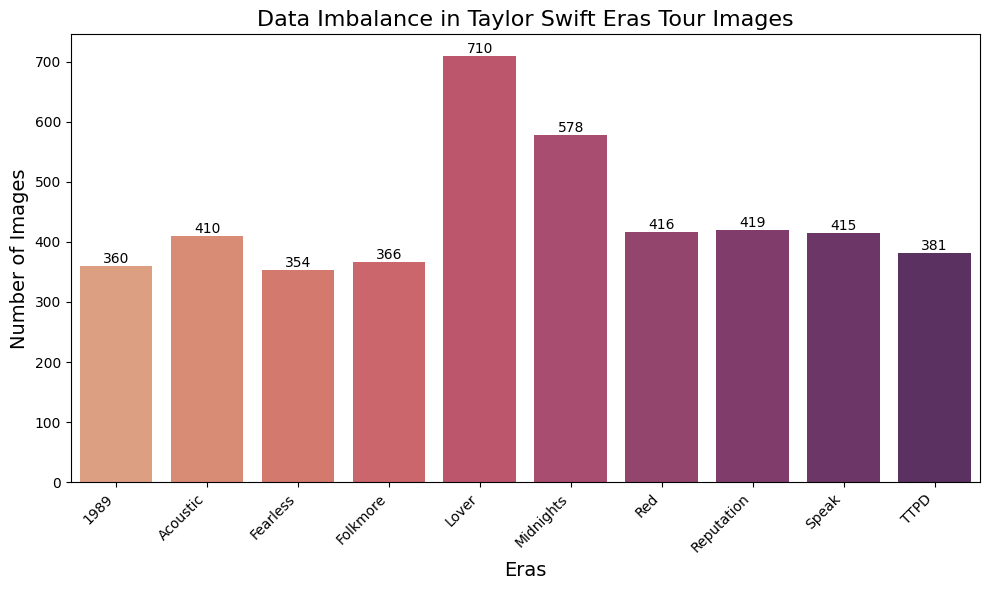

In [20]:
era_counts = {}

# Iterate through each subfolder (era)
for era_folder in os.listdir(main_folder):
    era_path = os.path.join(main_folder, era_folder)
    if os.path.isdir(era_path):
        # Count the number of images in the era folder
        era_counts[era_folder] = len([filename for filename in os.listdir(era_path) if filename.lower().endswith(('.jpg', '.jpeg', '.png'))])

# Create a pandas DataFrame from the era_counts dictionary
import pandas as pd
df = pd.DataFrame({'Era': era_counts.keys(), 'Image Count': era_counts.values()})

# Create the bar plot using seaborn
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
ax = sns.barplot(x='Era', y='Image Count', data=df, palette='flare')  # Choose a color palette you like
for bar in range(len(ax.containers)):
    ax.bar_label(ax.containers[bar])
# Customize the plot
plt.title('Data Imbalance in Taylor Swift Eras Tour Images', fontsize=16)
plt.xlabel('Eras', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout for better spacing

# Display the plot
plt.show()

In [21]:
def get_weight_inverse_num_samples(num_of_classes, samples_per_classes, coeff=1):
    """
    Get the inverse number of samples for each class.
    Args:
        num_of_classes (int): Number of classes in the dataset.
        samples_per_classes (list): List of number of samples per class.
        power (int, optional): Power of the inverse number of samples. Defaults to 1.
    Returns:
        list: List of inverse number of samples for each class.
    """

    inverse_num_samples = []
    total_samples = sum(samples_per_classes)

    for i in range(num_of_classes):
        inverse_num_samples.append((total_samples / (num_of_classes * samples_per_classes[i])) * coeff)

    return inverse_num_samples

num_of_classes = 10
samples_per_classes = [era_counts['1989'], era_counts['Acoustic'], era_counts['Fearless'], era_counts['Folkmore'], era_counts['Lover'], era_counts['Midnights'], era_counts['Red'], era_counts['Reputation'], era_counts['Speak'], era_counts['TTPD']] 

weighted_classes = get_weight_inverse_num_samples(num_of_classes, samples_per_classes)


In [22]:
class_indexes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [23]:
weights = dict(zip(class_indexes, weighted_classes))

In [24]:
weights

{1: 1.2247222222222223,
 2: 1.0753658536585367,
 3: 1.2454802259887006,
 4: 1.2046448087431694,
 5: 0.6209859154929578,
 6: 0.7628027681660899,
 7: 1.0598557692307693,
 8: 1.0522673031026253,
 9: 1.0624096385542168,
 10: 1.157217847769029}

Use pretrained model ResNet50 to experiment if we can have further improvements

In [25]:
conv_base = tf.keras.applications.ResNet50(
weights="imagenet",
include_top=False,
input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

Used pretrained model VGG16

In [26]:
#conv_base = tf.keras.applications.vgg16.VGG16(
#weights="imagenet",
#include_top=False,
#input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [27]:
for layer in conv_base.layers[:-12]:
    layer.trainable = False

In [28]:
conv_base.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 4,465,664 (17.04 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

In [29]:
from tensorflow.keras.regularizers import l2

In [30]:
inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

x = data_augmentation(inputs)

#x = resize_and_rescale(x)

x = tf.keras.applications.resnet.preprocess_input(x)
#x = tf.keras.applications.vgg16.preprocess_input(x)

#x = tf.keras.layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

#for size in [32, 64, 128, 256, 512]:

#    residual = x

#    x = tf.keras.layers.BatchNormalization()(x)
#    x = tf.keras.layers.Activation("relu")(x)
#    x = tf.keras.layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

#    x = tf.keras.layers.BatchNormalization()(x)
#    x = tf.keras.layers.Activation("relu")(x)
#    x = tf.keras.layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

#    x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
#    residual = tf.keras.layers.Conv2D(
#    size, 1, strides=2, padding="same", use_bias=False)(residual)
#    x = tf.keras.layers.add([x, residual])

#x = tf.keras.layers.GlobalAveragePooling2D()(x)
#x = tf.keras.layers.Dropout(0.7)(x)

x = conv_base(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.Dropout(0.1)(x)

outputs = tf.keras.layers.Dense(CLASSES, activation="softmax", kernel_regularizer=l2(0.001))(x)
#outputs = tf.keras.layers.Dense(CLASSES, activation="softmax")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [31]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [32]:
from tensorflow.keras import callbacks

In [33]:
filepath="saved_models/all_VGG16_models/best_model_weighted_VGG16.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
lr_plateau = callbacks.ReduceLROnPlateau(factor=0.8, monitor="val_accuracy", patience=5, verbose=1)
es = EarlyStopping(monitor='val_accuracy', patience=ES_EPOCHS)
callbacks_list = [checkpoint, es, lr_plateau]
#callbacks_list = [checkpoint, es]

In [34]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
    callbacks=callbacks_list,
    class_weight=weights
)

Epoch 1/500
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.3431 - loss: 3.4165
Epoch 1: val_accuracy improved from -inf to 0.60684, saving model to saved_models/all_VGG16_models/best_model_weighted_VGG16.keras
276/276 ━━━━━━━━━━━━━━━━━━━━ 202s 689ms/step - accuracy: 0.3436 - loss: 3.4131 - val_accuracy: 0.6068 - val_loss: 2.1480 - learning_rate: 1.0000e-05
Epoch 2/500
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.6988 - loss: 1.2772
Epoch 2: val_accuracy improved from 0.60684 to 0.68987, saving model to saved_models/all_VGG16_models/best_model_weighted_VGG16.keras
276/276 ━━━━━━━━━━━━━━━━━━━━ 191s 692ms/step - accuracy: 0.6989 - loss: 1.2770 - val_accuracy: 0.6899 - val_loss: 1.6917 - learning_rate: 1.0000e-05
Epoch 3/500
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.7842 - loss: 0.8785
Epoch 3: val_accuracy improved from 0.68987 to 0.75946, saving model to saved_models/all_VGG16_models/best_model_weighted_VGG16.keras
276/276 ━━━━━━━━━━━━━━━━━━━━ 189s 68

KeyboardInterrupt: 

In [36]:
filepath = "saved_models/all_VGG16_models/best_model_weighted_VGG16.keras"
best_model = tf.keras.models.load_model(filepath)

In [37]:
scores = best_model.predict(test_ds)

49/49 ━━━━━━━━━━━━━━━━━━━━ 25s 478ms/step


In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

NameError: name 'history' is not defined

In [ ]:
#EPOCHS = 113

#plt.figure(figsize=(8, 8))
#plt.subplot(1, 2, 1)
#plt.plot(range(EPOCHS), acc, label='Training Accuracy')
#plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
#plt.legend(loc='lower right')
#plt.title('Training and Validation Accuracy')

#plt.subplot(1, 2, 2)
#plt.plot(range(EPOCHS), loss, label='Training Loss')
#plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
#plt.legend(loc='upper right')
#plt.title('Training and Validation Loss')
#plt.show()

In [39]:
def create_list_y(dataset, model):
  y_true = []
  y_pred = []

  for x, y in dataset:
    y_true.append(y)
    y_pred.append(tf.argmax(model.predict(x),axis = 1))
    
  y_pred = tf.concat(y_pred, axis=0)
  y_true = tf.concat(y_true, axis=0)

  return y_pred, y_true

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

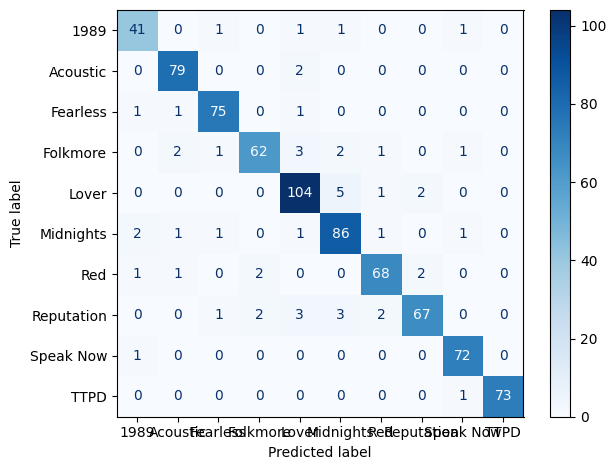

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

y_pred, y_true = create_list_y(test_ds, best_model)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)

disp.plot(cmap=plt.cm.Blues)
plt.tight_layout()
plt.show()

In [41]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

        1989       0.89      0.91      0.90        45
    Acoustic       0.94      0.98      0.96        81
    Fearless       0.95      0.96      0.96        78
    Folkmore       0.94      0.86      0.90        72
       Lover       0.90      0.93      0.92       112
   Midnights       0.89      0.92      0.91        93
         Red       0.93      0.92      0.93        74
  Reputation       0.94      0.86      0.90        78
   Speak Now       0.95      0.99      0.97        73
        TTPD       1.00      0.99      0.99        74

    accuracy                           0.93       780
   macro avg       0.93      0.93      0.93       780
weighted avg       0.93      0.93      0.93       780



In [42]:
from io import BytesIO
from PIL import Image

def read_file_as_img(file_path)-> np.ndarray:
    with open(file_path, 'rb') as f:
        data = f.read()
    image = np.array(Image.open(BytesIO(data)))

    return image

In [44]:
# Load the tensorflow model
PROD_MODEL_PATH = "saved_models/all_VGG16_models/best_model_weighted_VGG16.keras"

PROD_MODEL = tf.keras.models.load_model(PROD_MODEL_PATH)

In [48]:
img = read_file_as_img("images/lover2.jpg")

# Resize the image to 256x256
img = tf.image.resize(img, [256, 256]) 

# Predict the image classification
img_batch = np.expand_dims(img, 0)
predictions = PROD_MODEL.predict(img_batch)

predicted_class = CLASS_NAMES[np.argmax(predictions[0])]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


In [49]:
predicted_class

'Midnights'